In [1]:
#following example at https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation

import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [2]:
def animate(snapshots, file_name = "animation.gif"):


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-2.5, vmax=2.5)
    plt.colorbar()
    
    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)#, fps=30)


    print('Done! gif saved to ', file_name)


In [60]:
#loading data
data_path = '../data/npy/toy1.npy'
data = np.load(data_path)
print("data shape = ", data.shape)
data = torch.tensor(data).unsqueeze(1).float()
print("data shape = ", data.shape)

# dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)
dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=0, train_ratio=1.0,  valid_ratio=0.0, shuffle = False)
data,_,_ = dataset.obtain_data_at_current_level(level=0)

data = data[:,:,:-1,:-1]
print("data shape = ", data.shape)



data shape =  (500, 127, 127)
data shape =  torch.Size([500, 1, 127, 127])
data shape =  torch.Size([500, 1, 126, 126])


In [4]:
# #Prepare data loaders
train_loader = torch.utils.data.DataLoader(data, batch_size=50, num_workers=0)
# print(len(train_loader))
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=31, num_workers=0)

images shape =  (50, 1, 127, 127)


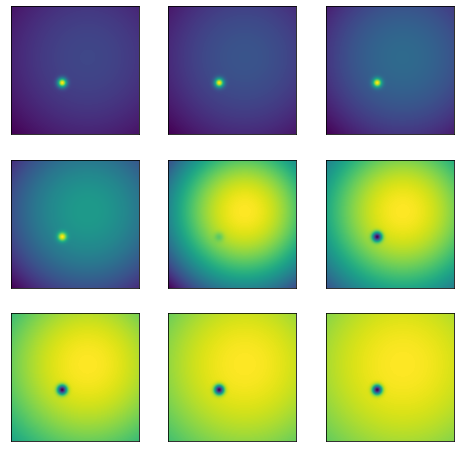

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display

print("images shape = ", images.shape)
#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

In [50]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, kernal_size=3, stride=2):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.convfirst = nn.Conv2d(1, 1, kernal_size, stride = stride, padding=0)  
        self.conv1 = nn.Conv2d(1, 1, 2, stride = 1, padding=1)  
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(1, 1, 2, stride=1, padding=1)
        self.t_conv_last = nn.ConvTranspose2d(1, 1, kernal_size, stride=stride, padding=0)


    def forward(self, x):
#         print("x start = ", x.shape)
        x = F.relu(self.convfirst(x))
#         print("x 1 = ", x.shape)
#         x = F.relu(self.conv1(x))
#         print("x 1 = ", x.shape)
#         x = F.relu(self.conv1(x))
#         print("x middle = ", x.shape)
# #         x = self.pool(x)
# #         print("x 2 = ", x.shape)
# #         x = F.relu(self.conv2(x))
# #         
# #         x = self.pool(x)
#         x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
#         print("x pad = ", x.shape)
#         x = F.relu(self.t_conv1(x))
#         print("x 4 = ", x.shape)
#         x = F.relu(self.t_conv1(x))
#         print("x 4 = ", x.shape)
        x = self.t_conv_last(x)
#         x = F.sigmoid(self.t_conv_last(x))
#         print("x before cut = ", x.shape)
#         x = x[:, :, 2:-2, 2:-2]
#         print("x end = ", x.shape)
#         gh
#         hjj
        return x

    def encode(self, x):
        x = F.relu(self.convfirst(x))
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv1(x))
        return x
    
    def decode(self, x):
#         x = torch.nn.functional.pad(x, (1, 1, 1, 1), 'replicate')
#         x = F.relu(self.t_conv1(x))
#         x = F.relu(self.t_conv1(x))
#         x = F.sigmoid(self.t_conv_last(x))
#         x = x[:, :, 2:-2, 2:-2]
        x = self.t_conv_last(x)
        
        return x

#Instantiate the model
model = ConvAutoencoder(63, 63)
print(model)
print(images.shape)
x = torch.tensor(images)[:,:,:126, :126]
print(x.shape)
predicted = model(x)

ConvAutoencoder(
  (convfirst): Conv2d(1, 1, kernel_size=(63, 63), stride=(63, 63))
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (t_conv1): ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (t_conv_last): ConvTranspose2d(1, 1, kernel_size=(63, 63), stride=(63, 63))
)
torch.Size([50, 1, 126, 126])
torch.Size([50, 1, 126, 126])


<ipython-input-50-9431b9b759db>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(images)[:,:,:126, :126]


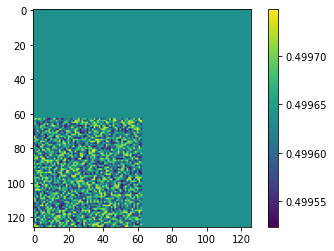

In [35]:
plt.imshow(predicted[10,0].detach().numpy())
plt.colorbar()

In [54]:
#Loss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()#reduction='none')

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (convfirst): Conv2d(1, 1, kernel_size=(63, 63), stride=(63, 63))
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (t_conv1): ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (t_conv_last): ConvTranspose2d(1, 1, kernel_size=(63, 63), stride=(63, 63))
)

In [56]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

#     i = 0
    #Training
    for images in train_loader:
#         print(images.shape)
        images = images.to(device)[:,:,:-1,:-1]
#         print("images = ", images.shape)
        optimizer.zero_grad()
        outputs = model(images)
#         print(outputs.shape)
#         fghj
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 3.769669
Epoch: 2 	Training Loss: 3.758845
Epoch: 3 	Training Loss: 3.748390
Epoch: 4 	Training Loss: 3.738291
Epoch: 5 	Training Loss: 3.728535
Epoch: 6 	Training Loss: 3.719111
Epoch: 7 	Training Loss: 3.710008
Epoch: 8 	Training Loss: 3.701215
Epoch: 9 	Training Loss: 3.692721
Epoch: 10 	Training Loss: 3.684509
Epoch: 11 	Training Loss: 3.676572
Epoch: 12 	Training Loss: 3.668903
Epoch: 13 	Training Loss: 3.661495
Epoch: 14 	Training Loss: 3.654320
Epoch: 15 	Training Loss: 3.647370
Epoch: 16 	Training Loss: 3.640651
Epoch: 17 	Training Loss: 3.634151
Epoch: 18 	Training Loss: 3.627858
Epoch: 19 	Training Loss: 3.621771
Epoch: 20 	Training Loss: 3.615880
Epoch: 21 	Training Loss: 3.610182
Epoch: 22 	Training Loss: 3.604669
Epoch: 23 	Training Loss: 3.599334
Epoch: 24 	Training Loss: 3.594171
Epoch: 25 	Training Loss: 3.589173
Epoch: 26 	Training Loss: 3.584334
Epoch: 27 	Training Loss: 3.579648
Epoch: 28 	Training Loss: 3.575109
Epoch: 29 	Training Loss: 3.5

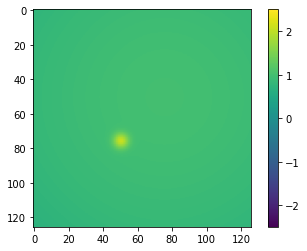

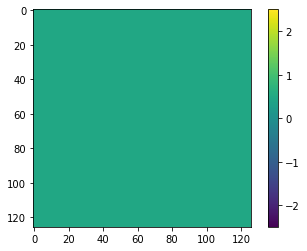

In [65]:
predicted = model(data)

plt.imshow(data[0,0],vmin=-2.5, vmax=2.5)
plt.colorbar()
plt.show()
plt.imshow(predicted[0,0].detach().numpy(), vmin = -2.5, vmax=2.5)
plt.colorbar()
plt.show()

Animating, may take a little while...
..................Done! gif saved to  conv_2x2_predicted.gif


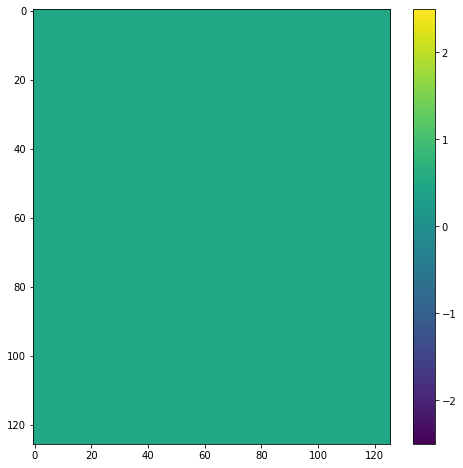

In [68]:
animate(predicted.detach().numpy(), "conv_2x2_predicted.gif")

In [57]:
#Batch of test images
dataiter = iter(train_loader)
images = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

print(images.shape)
batch_size = 50
output = output.view(batch_size, 1, 31, 31)#127, 127)
output = output.detach().numpy()

image_min = np.min(images)
image_max = np.max(images)
print("image_min = ", image_min)
print("image_max = ", image_max)

print("output min = ", np.min(output))
print("output max = ", np.max(output))
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    print(images[idx][0].shape)
    imshow(images[idx])#[0], vmin = -2.5, vmax = 2.5)
#     ax.set_title(classes[labels[idx]])
plt.colorbar()
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    plt.colorbar()
#     ax.set_title(classes[labels[idx]])
plt.show() 

(50, 1, 127, 127)


RuntimeError: shape '[50, 1, 31, 31]' is invalid for input of size 793800

torch.Size([10, 1, 31, 31])
(10, 1, 15, 15)


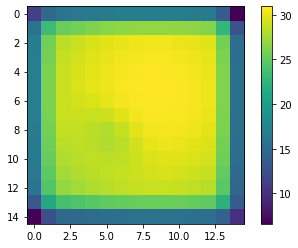

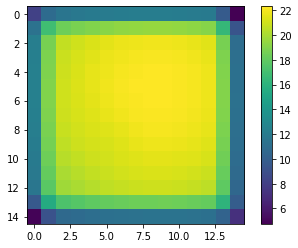

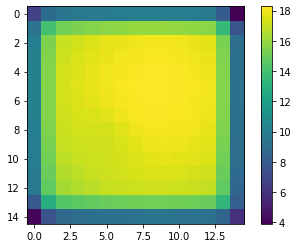

In [48]:
#Batch of test images
# dataiter = iter(train_loader)
# images = dataiter.next()
images = data[:10, :,:,:]
print(images.shape)
#encode and plot

encoded = model.encode(images).detach().numpy()
print(encoded.shape)

#encoded Images
plt.figure()
plt.imshow(encoded[0,0,:,:])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(encoded[1,0,:,:])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(encoded[2,0,:,:])
plt.colorbar()
plt.show()
# fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
# for idx in np.arange(5):
#     ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
#     imshow(encoded[idx])
# #     ax.set_title(classes[labels[idx]])
#     plt.colorbar()
# plt.show()

In [ ]:
import matplotlib.animation as animation
data_path = '../data/npy/toy1.npy'
data = np.load(data_path)
print("data shape = ", data.shape)
data = torch.tensor(data).unsqueeze(1).float()
print("data shape = ", data.shape)
print(data.shape)
# ghj
output = model(data)#.numpy()

print(images.shape)
batch_size = 500
output = output.view(batch_size, 1, 127, 127)
output = output.detach().numpy()

fps = 30
nSeconds = 50/fps
# snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

# a=output
snapshots = output
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0,:,:,:][0].T
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-2.5, vmax=2.5)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i,:,:,:,][0].T)
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps, # in ms
                               )
writergif = animation.PillowWriter(fps=30)
anim.save('Toy_1_Phi_simple_reconstruct.gif', writer=writergif)#, fps=30)


print('Done!')

# plt.show()  # Not required, it seems!

In [17]:

class MultiScaleDynamicsDataSet():
    def __init__(self, data_path, n_levels, t_array = None, map_path=None, train_ratio=0.7, valid_ratio=0.2, shuffle=True):
        # load data
        data = np.load(data_path)
        self.data = torch.tensor(data).unsqueeze(1).float()
        if t_array is None:
            self.t_array = torch.range(len(self.data)).float()
        else:
            self.t_array = torch.tensor(t_array).float()
        #
        if map_path is not None:
            map_data = 1 - np.load(map_path)
            self.map_data = torch.tensor(map_data).float()
        else:
            self.map_data = torch.ones(data.shape[-2:]).float()

        self.nt, self.nx, self.ny = data.shape
        # partition
        indices = np.arange(self.nt)
        if shuffle:
            np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.map_data = self.map_data.to(self.device)

    def obtain_data_at_current_level(self, level):
        train_data = self.data[self.train_inds].to(self.device)

        val_data = self.data[self.val_inds].to(self.device)
        test_data = self.data[self.test_inds].to(self.device)
        
        for i in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data
    
    def get_times(self):
        train_times = self.t_array[self.train_inds]
        val_times = self.t_array[self.val_inds]
        test_times = self.t_array[self.test_inds]
        
        return train_times, val_times, test_times

    def obtain_data_of_size(self, size_per_dim):
        train_data = self.data[self.train_inds].to(self.device)
        
        
        n_images, _, nx, ny = train_data.shape
#         print("n_images = ", n_images)
#         print("nx = ", nx)
#         print("ny = ", ny)
        
        stride_size = int(nx/size_per_dim)
#         print("stride_size = ", stride_size)
        
        op = torch.nn.Conv2d(1, 1, stride_size, stride=stride_size, padding=0).to(device)
#         print("op.weight.data= ", op.weight.data.shape)
        n = 1
        for i in range(n):
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / (stride_size **2)
        new_train_data = op(train_data)
#         print("new_train_data shape = ", new_train_data.shape)
        
#         for i in range(self.n_levels - 1):
#             train_data = apply_local_op(train_data, self.device, ave=False)

        return new_train_data
        
        
        
def apply_local_op(data, device, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels, _, _ = data.size()
    print("data size = ", data.shape)
    n = min(in_channels, out_channels)
    if mode == 'conv':
        op = torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    elif mode == 'deconv':
        op = torch.nn.ConvTranspose2d(out_channels, out_channels, 3, stride=2, padding=0).to(device)
    else:
        raise ValueError('mode can only be conv or deconv!')
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)

    for i in range(n):
        if mode == 'conv':
            if ave:
                op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 9
            else:
                op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size()).to(device)
        elif mode == 'deconv':
            op.weight.data[i, i, :, :] = torch.ones(op.weight.data[i, i, :, :].size()).to(device) / 4
            op.weight.data[i, i, 0, 1] += 1 / 4
            op.weight.data[i, i, 1, 0] += 1 / 4
            op.weight.data[i, i, 1, 2] += 1 / 4
            op.weight.data[i, i, 2, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 4
            op.weight.data[i, i, 1, 1] += 1 / 2

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    return op(data)


def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

t = np.linspace(0, 8*np.pi, 500)
dataset_new = MultiScaleDynamicsDataSet(data_path, n_levels=3, t_array = t, train_ratio=1.0, valid_ratio=0.0, shuffle=False)
data_new = dataset_new.obtain_data_of_size(2).detach().numpy()
train_times, _, _ = dataset_new.get_times()

print(train_times)

cpu
tensor([ 0.0000,  0.0504,  0.1007,  0.1511,  0.2015,  0.2518,  0.3022,  0.3526,
         0.4029,  0.4533,  0.5037,  0.5540,  0.6044,  0.6548,  0.7051,  0.7555,
         0.8059,  0.8562,  0.9066,  0.9570,  1.0073,  1.0577,  1.1081,  1.1584,
         1.2088,  1.2592,  1.3095,  1.3599,  1.4103,  1.4606,  1.5110,  1.5614,
         1.6117,  1.6621,  1.7125,  1.7628,  1.8132,  1.8635,  1.9139,  1.9643,
         2.0146,  2.0650,  2.1154,  2.1657,  2.2161,  2.2665,  2.3168,  2.3672,
         2.4176,  2.4679,  2.5183,  2.5687,  2.6190,  2.6694,  2.7198,  2.7701,
         2.8205,  2.8709,  2.9212,  2.9716,  3.0220,  3.0723,  3.1227,  3.1731,
         3.2234,  3.2738,  3.3242,  3.3745,  3.4249,  3.4753,  3.5256,  3.5760,
         3.6264,  3.6767,  3.7271,  3.7775,  3.8278,  3.8782,  3.9286,  3.9789,
         4.0293,  4.0797,  4.1300,  4.1804,  4.2308,  4.2811,  4.3315,  4.3819,
         4.4322,  4.4826,  4.5330,  4.5833,  4.6337,  4.6841,  4.7344,  4.7848,
         4.8352,  4.8855,  4.9359,  

In [8]:
plt.figure()
plt.imshow(data_new[0][0])
plt.colorbar()
plt.show()

animate(data_new, file_name = "2x2.gif")

NameError: name 'data_new' is not defined

<Figure size 432x288 with 0 Axes>

In [9]:
animate(data_new[:50], file_name = "2x2_small.gif")

NameError: name 'data_new' is not defined

In [48]:
#now we want to evolve our 2x2 forward in time

class time_net(nn.Module):
    def __init__(self):
        super(time_net, self).__init__()
#         self.new_thing = nn.Linear(4, 32)
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 4)

    # x represents our data
    def forward(self, x):
#         print("x shape start = ", x.shape)
        x = self.fc1(x)
        x = F.relu(x)
#         print("x shape = ", x.shape)
        x = F.relu(self.fc2(x))
#         print("x shape = ", x.shape)
        x = self.fc3(x)
#         print("x shape end = ", x.shape)
        return x

time_model = time_net()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(time_model.parameters(), lr=1e-3)

inputs = torch.tensor(data_new[:-1])
inputs = torch.flatten(inputs, start_dim=1, end_dim=-1)
print("inputs.shape = ", inputs.shape)
outputs = torch.tensor(data_new[1:])
outputs = torch.flatten(outputs, start_dim=1, end_dim=-1)
print("outputs.shape = ", outputs.shape)
n_epochs = 50000
for t in range(n_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    predicted = time_model(inputs)
    
#     print("inputs.shape = ", inputs.shape)
#     print("predicted.shape = ", predicted.shape)
#     print("outputs.shape = ", outputs.shape)

    # Compute and print loss
    loss = criterion(predicted, outputs)
    if t % 1000 == 0:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

inputs.shape =  torch.Size([499, 4])
outputs.shape =  torch.Size([499, 4])
0 0.4547992944717407
1000 0.3630325496196747
2000 0.23146888613700867
3000 0.07442664355039597
4000 0.012775764800608158
5000 0.0040060169994831085
6000 0.002863827394321561
7000 0.002476178575307131
8000 0.0022673022467643023
9000 0.002122598933055997
10000 0.0019982026424258947
11000 0.001889229635708034
12000 0.0017937965458258986
13000 0.00170879194047302
14000 0.0016310664359480143
15000 0.0015588555252179503
16000 0.0014920382527634501
17000 0.0014316907618194818
18000 0.0013756133848801255
19000 0.0013229947071522474
20000 0.001273280126042664
21000 0.001226490014232695
22000 0.0011823143577203155
23000 0.0011406302219256759
24000 0.0011013796320185065
25000 0.0010644360445439816
26000 0.0010295127285644412
27000 0.000996679300442338
28000 0.0009656921029090881
29000 0.0009365021251142025
30000 0.0009091157116927207
31000 0.0008834220352582633
32000 0.0008594205137342215
33000 0.0008367273840121925
34000 

(499, 1, 2, 2)


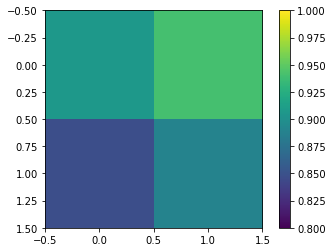

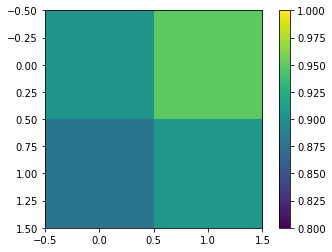

In [49]:
predicted = time_model(inputs).reshape(499, 1, 2, 2).detach().numpy()

print(predicted.shape)
plt.figure()
plt.imshow(predicted[0][0],vmin = .8, vmax = 1.0)
plt.colorbar()
plt.show()

inputs_np = inputs.reshape(499, 1, 2, 2).detach().numpy()
plt.figure()
plt.imshow(inputs_np[1][0],vmin = .8, vmax = 1.0)
plt.colorbar()
plt.show()

Animating, may take a little while...
..................Done! gif saved to  2x2_predicted.gif


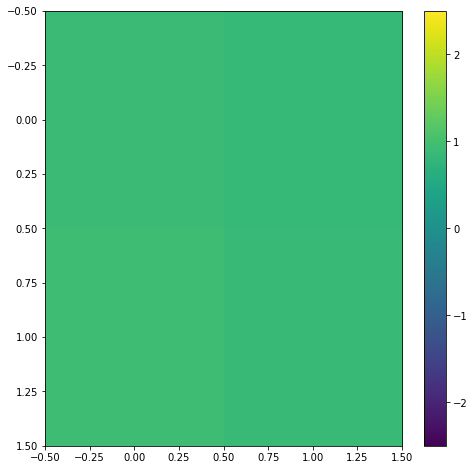

In [50]:
animate(predicted, "2x2_predicted.gif")

(499,)


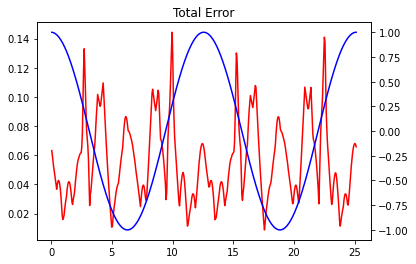

In [84]:
mse = np.sqrt((inputs_np[:,0] - predicted[:,0])**2)
total_mse = mse[:,0,0] + mse[:,0,1] + mse[:,1,0] + mse[:,1,1]
print(total_mse.shape)


t = np.linspace(0, 8*np.pi, 500)
w0 = 0.5

fig,ax = plt.subplots()
ax.plot(t[1:],total_mse, "r")
# ax.set_y_label("MSE")
ax2=ax.twinx()
ax2.plot(t[1:], np.cos(w0*t[1:]),"b")
plt.title("Total Error")
plt.show()

(499, 1, 2, 2)


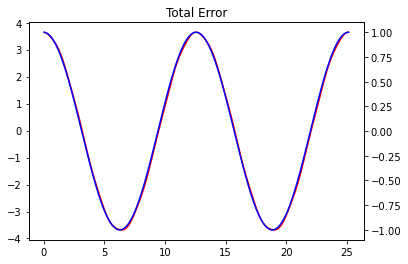

In [82]:
print(inputs_np.shape)
sum_all  = inputs_np[:,:,0,0] + inputs_np[:,:,0,1] + inputs_np[:,:,1,0] + inputs_np[:,:,1,1]
sum_all.shape
# plt.plot(sum_all)

fig,ax = plt.subplots()
ax.plot(t[1:],sum_all, "r")
# ax.set_y_label("MSE")
ax2=ax.twinx()
ax2.plot(t[1:], np.cos(w0*t[1:]),"b")
plt.title("Sum of all points")
plt.show()

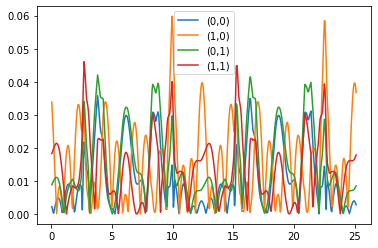

In [86]:
plt.figure()

mse = np.sqrt((inputs_np[:,0] - predicted[:,0])**2)

plt.plot(t[1:], mse[:,0,0], label = "(0,0)")
plt.plot(t[1:], mse[:,1,0], label = "(1,0)")
plt.plot(t[1:], mse[:,0,1], label = "(0,1)")
plt.plot(t[1:], mse[:,1,1], label = "(1,1)")
plt.legend()
plt.show()